# Linear Regression Model – House Price Prediction

This notebook implements **Multiple Linear Regression** to predict house prices using Kaggle’s House Prices dataset. The target variable was log-transformed to stabilize variance, and a preprocessing pipeline was used to clean and encode both numerical and categorical features. Linear Regression serves as a baseline model for comparison due to its simplicity and interpretability.

Using the Kaggle **"House Prices – Advanced Regression Techniques"** dataset, the goal is to obtain the **Mean Squared Error (MSE)**, **Root Mean Squared Error (RMSE)**, **Mean Absolute Error (MAE)**, and log-space metrics**, which are then used to generate the residual plot, error histogram, and actual vs. predicted plots.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression

In [14]:
# Load dataset (adjust path if needed)
df = pd.read_csv("train.csv")
print("Shape:", df.shape)
df.head()


Shape: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
# Target variable transformation
y_raw = df["SalePrice"]
y = np.log1p(y_raw)

# Features dataframe 
X = df.drop("SalePrice", axis=1)

# Identify numeric and categorical features
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric features:", len(num_features))
print("Categorical features:", len(cat_features))

# ------ Preprocessing pipelines --------
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)

# ------- Train/validation split --------
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_valid.shape

Numeric features: 37
Categorical features: 43


((1168, 80), (292, 80))

In [16]:
# ------- Evaluate metrics on original SalePrice scale after inverse log1p transformation --------
def eval_metrics(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)  
    y_pred = np.expm1(y_pred_log)
    
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true_log, y_pred_log)  # R^2 in log-space
    
    return mse, mae, rmse, r2

# ------- Plotting functions --------
def plot_residuals_and_errors(name, y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    residuals = y_true - y_pred
    
    plt.figure(figsize=(12,4))
    
    # Residual plot
    plt.subplot(1, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("Predicted SalePrice")
    plt.ylabel("Residual (True - Pred)")
    plt.title(f"{name} – Residual Plot")

    # Format x-axis with commas
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{int(x):,}"))

    plt.grid(alpha=0.3)

    # Residual histogram
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, bins=40, kde=True, stat="density", alpha=0.6)
    plt.xlabel("Residual")
    plt.ylabel("Density")
    plt.title(f"{name} – Residual Histogram")

    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# ------- Actual vs Predicted Plot -------- 
def plot_actual_vs_pred(name, y_true_log, y_pred_log):
    # Convert log1p values back to real SalePrice
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    
    plt.figure(figsize=(10,5))
    plt.scatter(y_true, y_pred, alpha=0.5)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], "r--", label="Perfect Fit")
    
    plt.xlabel("Actual SalePrice ($)")
    plt.ylabel("Predicted SalePrice ($)")
    plt.title(f"{name} – Actual vs Predicted")
    
    # Format axis with commas
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{int(x):,}"))
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f"{int(x):,}"))
    
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [17]:
# Linear Regression pipeline
linear_reg = LinearRegression()

pipe_lr = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", linear_reg),
])

# Fit and evaluate
pipe_lr.fit(X_train, y_train)
y_valid_pred_lr = pipe_lr.predict(X_valid)

mse, mae, rmse, r2 = eval_metrics(y_valid, y_valid_pred_lr)
print("=== Linear Regression ===")
print(f"MSE  (original $): {mse:,.2f}")
print(f"MAE  (original $): {mae:,.2f}")
print(f"RMSE (original $): {rmse:,.2f}")
print(f"R^2  (log-space) : {r2:.4f}")

=== Linear Regression ===
MSE  (original $): 517,314,998.72
MAE  (original $): 14,894.04
RMSE (original $): 22,744.56
R^2  (log-space) : 0.9122


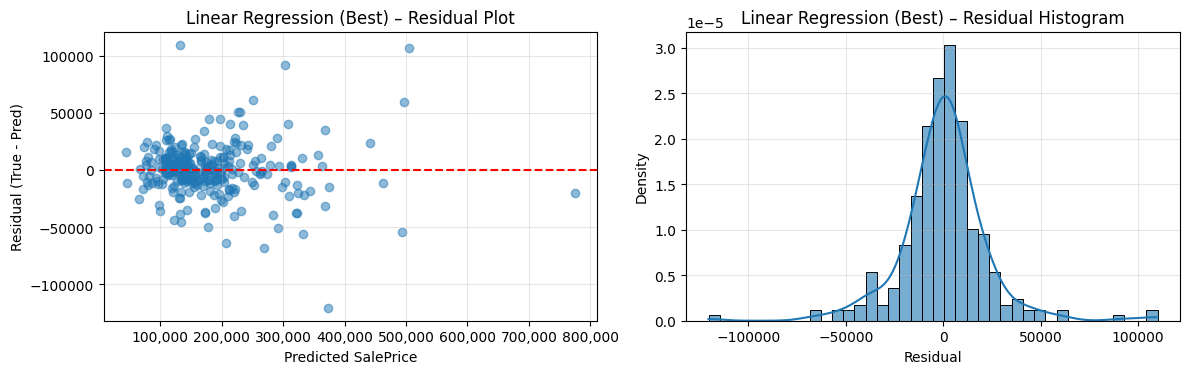

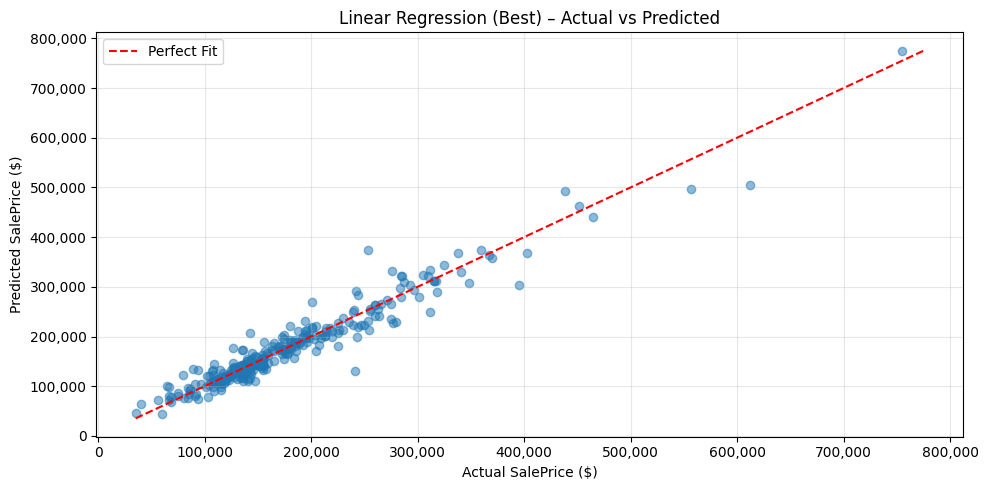

In [18]:
# Residuals and error histogram
plot_residuals_and_errors("Linear Regression (Best)", y_valid, y_valid_pred_lr)

# Actual vs Predicted plot
plot_actual_vs_pred("Linear Regression (Best)", y_valid, y_valid_pred_lr)